In [56]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from scipy.linalg import expm
import itertools
from tqdm import tqdm
import pandas as pd
import qutip as qt
from qutip.solver import Options
from qutip.parallel import parallel_map
qt.settings.num_cpus

8

In [5]:
# ------------------------
# parâmetros 
# ------------------------
m = 5                     # número de qubits (QPE)
N = 30                    # dimensão de Fock do modo de cavidade
kappa = 1.0               # taxa de decaimento do modo
chi_base = 1.0            # "acoplamento base" (define as fases binárias)
with_dissipation = True  # Incluir dissipação durante a evolução dispersiva

# malha no espaço de fase (para Wigner final W(x,y))
xmax = 5.0
ngr = 25
x = np.linspace(-xmax, xmax, ngr)
y = np.linspace(-xmax, xmax, ngr)
X, Y = np.meshgrid(x, y)
alpha_grid = (X + 1j*Y)

# ------------------------
# Operadores do campo e dos qubits
# ------------------------
a = qt.destroy(N)
num = a.dag()*a
I_cav = qt.qeye(N)
sz = qt.sigmaz()
sy = qt.sigmay()
I2 = qt.qeye(2)

def tens_qubit(op, k, m):
    """coloca 'op' no qubit k (0 = LSB) e identidade nos demais."""
    ops = []
    for j in range(m):
        ops.append(op if j == k else I2)
    out = ops[0]
    for j in range(1, m):
        out = qt.tensor(out, ops[j])
    return out

def tens_all_qubits(op):
    """op ^ m (m cópias tensoriais do operador 'op')."""
    out = op
    for _ in range(m-1):
        out = qt.tensor(out, op)
    return out

def kron_cav_qubits(op_cav, op_qubits):
    return qt.tensor(op_cav, op_qubits)

# Hadamard "físico": rotações Ry(±π/2)
def Ry(theta):
    return (-1j * theta/2 * sy).expm()

H_pi2 = Ry(np.pi/2)
Hm_pi2 = Ry(-np.pi/2)

H_pi2_all = tens_all_qubits(H_pi2)
Hm_pi2_all = tens_all_qubits(Hm_pi2)

# ------------------------
# construção do Hamiltoniano dispersivo e evolução
# ------------------------
# fases binárias: theta_k = chi_k * t. Queremos:
#    theta_0 = pi   (paridade)
#    theta_{k>=1} = 2^k * pi  (múltiplos de 2π -> identidade)
# Podemos impor um único tempo t e definir chi_k = chi_base * 2**k, com t = pi/chi_base.
chis = [chi_base * (2**k) for k in range(m)]
t_total = np.pi / chi_base  # assim theta_0 = pi

# operador S = sum_k chi_k * sz_k (atua só nos qubits)
S_qubits = 0
for k in range(m):
    S_qubits = S_qubits + chis[k] * tens_qubit(sz, k, m)

# Hamiltoniano dispersivo: H = (a† a) ⊗ S_qubits
H = kron_cav_qubits(num, S_qubits)

# colapsos (só cavidade aqui; pode-se acrescentar T1/Tphi dos qubits, se quiser)
c_ops = []
if with_dissipation and kappa > 0:
    c_ops = [np.sqrt(kappa) * qt.tensor(a, tens_all_qubits(I2))]

# ------------------------
# estado inicial do campo (edite à vontade)
# ------------------------
# Ex.: estado "gato" |alpha0> + |-alpha0>
alpha0 = 1.8
cat_norm = 1/np.sqrt(2*(1+np.exp(-2*alpha0**2)))
psi_cat = cat_norm * (qt.coherent(N, alpha0) + qt.coherent(N, -alpha0))
rho_cav0 = qt.ket2dm(psi_cat)
# (troque por estado coerente puro se preferir:)
rho_cav0 = qt.coherent_dm(N, 1.2)

# qubits começam em |g...g>, depois aplicamos Ry(π/2) para ficar em |+...+>
g = qt.basis(2, 1)  # convenção: |g>=|1>, |e>=|0> (ajuste se a sua for diferente)
psi_qubits0 = qt.tensor(*([g] * m))
rho_qubits0 = qt.ket2dm(psi_qubits0)

# ------------------------
# medição de ΔP(α/2) e reconstrução de W(α)=2ΔP(α/2)
# ------------------------
W_rec = np.zeros_like(X, dtype=float)

# projetores para ler P_e e P_g do qubit LSB após a sequência
# Vamos medir <σ_z> no LSB -> ΔP = <σ_z>
Pi_e = qt.ket2dm(qt.basis(2, 0))
Pi_g = qt.ket2dm(qt.basis(2, 1))
proj_e_LSB = tens_qubit(Pi_e, 0, m)
proj_g_LSB = tens_qubit(Pi_g, 0, m)
sigz_LSB = proj_e_LSB - proj_g_LSB

Id_qubits = tens_all_qubits(I2)
Id_total = qt.tensor(I_cav, Id_qubits)

# pré/pós pulsos de Ramsey em todos os qubits (poderia ser só no LSB; aqui uso todos)
U_pre  = qt.tensor(I_cav, H_pi2_all)
U_post = qt.tensor(I_cav, Hm_pi2_all)

# evolução unitária (ou mesolve) por t_total
def evolve_rho(rho0):
    if with_dissipation and kappa > 0:
        out = qt.mesolve(H, rho0, [0, t_total, 10], c_ops=c_ops, e_ops=[])
        return out.states[-1]
    else:
        U = (-1j * H * t_total).expm()
        return U * rho0 * U.dag()

# loop na malha: usamos a relação do PRL W(β)=2ΔP(β/2)
for ix in range(ngr):
    for iy in range(ngr):
        beta = alpha_grid[iy, ix]                 # ponto desejado para W(β)
        alpha_half = beta/2.0                     # vamos medir ΔP(β/2)
        D = qt.displace(N, alpha_half)
        rho_cav = D * rho_cav0 * D.dag()

        # estado total inicial e pré-pulso
        rho0 = qt.tensor(rho_cav, rho_qubits0)
        rho1 = U_pre * rho0 * U_pre.dag()

        # evolução dispersiva
        rho2 = evolve_rho(rho1)

        # pós-pulso e leitura
        rho3 = U_post * rho2 * U_post.dag()
        # ΔP = <σ_z(LSB)>
        deltaP = (rho3 * qt.tensor(I_cav, sigz_LSB)).tr().real

        # Wigner reconstruída
        W_rec[iy, ix] = 2.0 * deltaP

# ------------------------
# (opcional) comparação com wigner() direta do QuTiP
# ------------------------
compare_with_direct = True
if compare_with_direct:
    # wigner direta da QuTiP no mesmo grid (β = x+iy)
    W_direct = qt.wigner(rho_cav0, x, y)  
else:
    W_direct = None

# ------------------------
# plots 2D e 3D lado a lado
# ------------------------
# 2D
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
c = ax1.contourf(x, y, W_rec, levels=100)
fig.colorbar(c, ax=ax1, shrink=0.8)
ax1.set_title("Wigner via paridade deslocada (equivalente ao QPE)")
ax1.set_xlabel("Re(β)"); ax1.set_ylabel("Im(β)")

# 3D
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(X, Y, W_rec, rstride=2, cstride=2, linewidth=0, antialiased=True)
ax2.set_title("Wigner - 3D")
ax2.set_xlabel("Re(β)"); ax2.set_ylabel("Im(β)"); ax2.set_zlabel("W")

plt.tight_layout()
plt.show()

# (opcional) figura de comparação
W_direct = qt.wigner(rho_cav0, x, y)  # <- vetores 1D (hotfix)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.contourf(x, y, W_rec,    levels=100); plt.title("Paridade (QPE-equivalente)")
plt.subplot(1,3,2)
plt.contourf(x, y, W_direct, levels=100); plt.title("qutip.wigner()")
plt.subplot(1,3,3)
plt.contourf(x, y, W_rec - W_direct, levels=100); plt.title("diferença (normalizações podem variar)")

plt.tight_layout()
plt.show()

#qutip.wigner usa uma convenção de normalização própria; a nossa vem da relação ΔP do PRL. Pode sobrar um fator global. Para comparar só a forma, você pode reescalar um pelo máximo do outro:
#W_rec_scaled = W_rec * (W_direct.max() / W_rec.max())


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

# Alternativa para a função de Wigner: $W(\alpha) = 2 \sum P(n)(-1)^m$

Calculado W(alpha=(2.0,2.0)) = 0.113897
Tempo total de cálculo da Wigner: 102.24 segundos


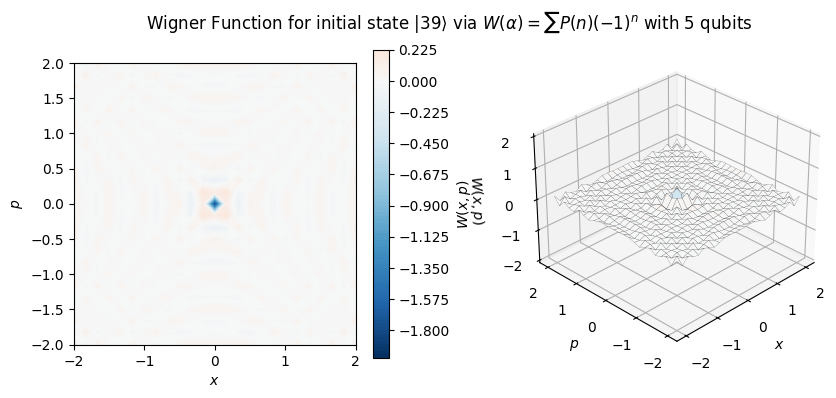

In [67]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")

    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)                                  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)                               # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)                                    # Matriz de fase para cada combinação de estados
    P = np.exp(P)                                          # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]                               # Dimensão da matriz
    
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)


def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
        
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total


def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    state_i_field = qt.fock(dim_f, N) #qt.coherent(dim_f, np.sqrt(N))#
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i


def construir_base_qubits(num_qubits):
    # Gera a lista 'basis_states' com todos os estados computacionais dos qubits
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states


# liga H_eff até t_f_int e desliga depois
def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0


# Purificação: a partir do estado total (qubits + campo), extrai a parte do campo e constrói um estado puro aproximado como superposição coerente dos autovetores da matriz densidade reduzida.
def construir_estado_puro_do_campo(state_total, num_qubits):

    # Traço parcial sobre os qubits para obter o estado do campo
    rho_f = state_total.ptrace(num_qubits)

    # Obter autovalores e autovetores
    vals, vecs = rho_f.eigenstates()

    # Construir estado puro como superposição coerente ponderada
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))

    # Normalizar
    return state_f_puro.unit()


def last_state_qobj(result, template_state=None):
    """
    Pega o 'último estado' de result.states, independentemente de ser
    lista/tupla/array aninhado, e devolve como Qobj.
    """
    x = result.states
    # Desce até chegar num Qobj
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    # Caso extremo: veio como vetor/array numérico — reconstrói como ket.
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        # fallback: tudo em uma única Hilbert; funciona, mas prefira passar template_state
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

# Escrever na base deslocada o estado inicial
def apply_displacement(rho_or_ket, alpha, dim_f_disp):
    D = qt.displace(dim_f_disp, alpha)
    if rho_or_ket.isket:
        return D * rho_or_ket
    else: # isbra or isoper
        return D * rho_or_ket * D.dag()  

# Aplicar a QPE para obter a distribuição de fótons
def Pn_via_QPE(state_i_qubits, state_displaced, H_td, t_f_int, t_list_round, c_ops, opts, seed_t, proj_list_qft):
        
    # Estado inicial total 
    state_i = qt.tensor(state_i_qubits + [state_displaced])

    # Evolução: interação + livre
    
    ## Garantir mesma semente nessa trajetória
    qt.settings.mc_seed = seed_t
    
    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None, 
                    args={"t_f_int": t_f_int},
                    options=opts, ntraj=1, progress_bar=None)
        
    #1° [-1]: estado final de cada tempo; 2° [-1]: estado final do último instante de tempo
    state_f = data.states[-1][-1]

    # Probabilidade
    probs = np.real(qt.expect(proj_list_qft, state_f))
    probs = np.clip(probs, 0.0, 1.0)
    s = probs.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs /= s
        
    return probs


# =========================
# parâmetros 
# =========================
num_qubits = 5                                    # Número de qubits
N_max = 2 ** num_qubits                           # Restringe valores recuperáveis (precisão ~ 1/2**num_qubits)
dim_q = 2                                         # Dimensão dos qubits
dim_f = N_max+1                                   # Dimensão do campo (tem de ser maior que N_max)
N = 39                                            # Número de fótons do campo (idealmente ser <dim_f

kappa = 1.0                                       # Decaimento da cavidade (aqui ligado pq parametriza outros parâmetros, mas na prática é nulo no código)
num_qpe = 1                                       # Número de QPE's

# Escala de tempo
t_f_int = 1.0e-3 * (1.0 / kappa) 
t_list_round = np.array([0.0, t_f_int])

# Calibração dos acoplamentos: g_k * t_f_int = 2π * 2^k / N_max
g_list = [ (2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits) ]
g_list = g_list[::-1]  


# =========================================================
# Operadores & estados
# =========================================================
sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
n_op = a.dag() * a

state_i_qubits, state_i_field, state_i = preparar_estado_inicial(num_qubits, dim_f, N)

# ρ_qubits = |+><+|^{⊗m} para re-preparar entre rodadas
rho_plus_single = (qt.basis(2,0) + qt.basis(2,1)).unit()
rho_plus_qubits = qt.tensor([ (rho_plus_single * rho_plus_single.dag()) for _ in range(num_qubits) ])

# Projetores (IQFT + base computacional)
basis_states = construir_base_qubits(num_qubits)
proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]

# Colapsos e Hamiltonianos
c_ops   = [np.sqrt(1.0) * a]
H_eff   = 0
for q in range(num_qubits):
    H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
H_free  = 0 * H_eff  # Hamiltoniano nulo com mesmas dims

H_td = [[H_eff, c_eff]]

# =========================
# Evolução via Monte Carlo (SE sem decoerência)
# =========================
   
prob_global_ntraj_list = np.zeros((num_qpe, 2**num_qubits), dtype=float)
mean_photons = np.zeros(num_qpe, dtype=float)

# Options
opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
               store_states=False, store_final_state=True)

# Gerar semente única por trajetória para garantir continuidade da trajetória estocástica
seed_t = np.random.randint(1e9)

# Definindo o parâmetro de deslocamento alpha
grid_max = 2.0
xvec = np.linspace(-grid_max, grid_max, 25) 
pvec= np.linspace(-grid_max, grid_max, 25)
wigner_data = np.zeros((len(xvec), len(pvec)))

start_time = time.time()
for i, p in enumerate(pvec):
    for j, x in enumerate(xvec):
        alpha = x + 1j * p
 
        # 1. Deslocar o estado inicial
        alpha = - alpha                                                       # W(-alpha)
        state_displaced = apply_displacement(state_i_field, alpha, dim_f)
        
        # 2. Obter P(n) do estado deslocado usando a QPE 
        Pn_displaced = Pn_via_QPE(state_i_qubits, state_displaced, H_td, t_f_int, t_list_round, c_ops, opts, seed_t, proj_list_qft)
        
        # 3. Calcular Wigner usando a soma
        # A soma vai de n=0 até max_n_qpe = 2^num_anc_qpe - 1
        # Determina o limite superior (dimensão da truncagem e número de possibilidades) 
        # para que ao escolher uma base grande, ela não extrapole o número de fótons distinguíveis pela QPE
        max_n_sum = min(dim_f - 1, (2 ** num_qubits) - 1)      
        
        w = sum(Pn_displaced[n] * ((-1) ** n) for n in range(max_n_sum + 1))

        wigner_data[i, j] = 2.0 * w
        
        print(f"Calculado W(alpha=({x:.1f},{p:.1f})) = {wigner_data[i,j]:.3f}", end='\r')

end_time = time.time()
print(f"\nTempo total de cálculo da Wigner: {end_time - start_time:.2f} segundos")

    
        
# --- Plotar a Função de Wigner

X_w, P_w = np.meshgrid(xvec, pvec)
fig = plt.figure(figsize=(10, 4))
fig.suptitle(rf"Wigner Function for initial state $|{N}\rangle$ via $W(\alpha) = \sum P(n)(-1)^n$ with {num_qubits} qubits", fontsize=12)

# Subplot 2D
ax1 = fig.add_subplot(1, 2, 1)
cont = ax1.contourf(X_w, P_w, wigner_data, 100, cmap='RdBu_r', vmin=-2, vmax=2)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$p$")
ax1.set_aspect('equal')
cb1 = fig.colorbar(cont, ax=ax1)
cb1.set_label(r"$W(x, p)$")

# Subplot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X_w, P_w, wigner_data, cmap='RdBu_r', vmin=-2, vmax=2, edgecolor='k', linewidth=0.1)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$p$")
ax2.set_zlabel(r"$W(x, p)$")
ax2.set_zlim(-2,2) # Fixar escala Z
ax2.view_init(elev=30, azim=-135)

#plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Trabalhando com estados coerentes e de gato (paralelizado em $\alpha$)

Simulação começou
10.1%. Run time: 625.89s. Est. time left: 00:01:33:19
20.0%. Run time: 1170.23s. Est. time left: 00:01:17:47
30.0%. Run time: 1715.91s. Est. time left: 00:01:06:35
40.0%. Run time: 2241.54s. Est. time left: 00:00:55:57
50.0%. Run time: 2755.44s. Est. time left: 00:00:45:52
60.0%. Run time: 3285.33s. Est. time left: 00:00:36:28
70.0%. Run time: 3833.29s. Est. time left: 00:00:27:21
80.0%. Run time: 4377.07s. Est. time left: 00:00:18:13
90.0%. Run time: 4911.19s. Est. time left: 00:00:09:05
100.0%. Run time: 5472.08s. Est. time left: 00:00:00:00
Total run time: 5472.13s

Tempo total de cálculo da Wigner (paralelo): 5472.13 segundos


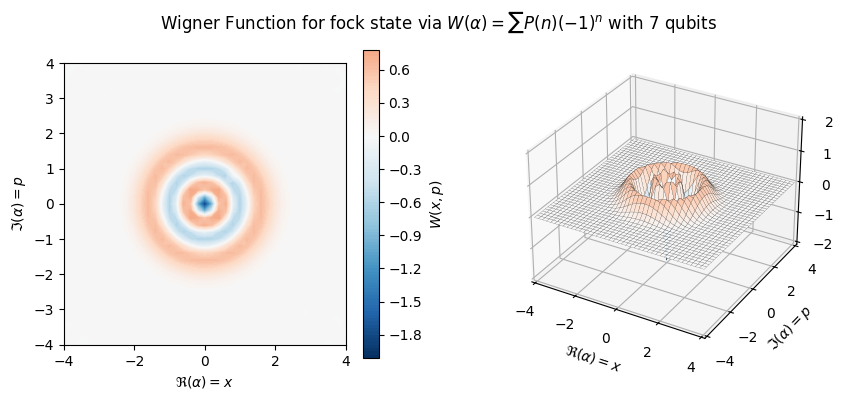

In [55]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")

    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)                                  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)                               # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)                                    # Matriz de fase para cada combinação de estados
    P = np.exp(P)                                          # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]                               # Dimensão da matriz
    
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)


def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
        
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total


def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    state_i_field = qt.fock(dim_f, N) #qt.coherent(dim_f, np.sqrt(N))#
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i


def construir_base_qubits(num_qubits):
    # Gera a lista 'basis_states' com todos os estados computacionais dos qubits
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states


# liga H_eff até t_f_int e desliga depois
def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0


# Purificação: a partir do estado total (qubits + campo), extrai a parte do campo e constrói um estado puro aproximado como superposição coerente dos autovetores da matriz densidade reduzida.
def construir_estado_puro_do_campo(state_total, num_qubits):

    # Traço parcial sobre os qubits para obter o estado do campo
    rho_f = state_total.ptrace(num_qubits)

    # Obter autovalores e autovetores
    vals, vecs = rho_f.eigenstates()

    # Construir estado puro como superposição coerente ponderada
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))

    # Normalizar
    return state_f_puro.unit()


def last_state_qobj(result, template_state=None):
    """
    Pega o 'último estado' de result.states, independentemente de ser
    lista/tupla/array aninhado, e devolve como Qobj.
    """
    x = result.states
    # Desce até chegar num Qobj
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    # Caso extremo: veio como vetor/array numérico — reconstrói como ket.
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        # fallback: tudo em uma única Hilbert; funciona, mas prefira passar template_state
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

# Escrever na base deslocada o estado inicial
def apply_displacement(rho_or_ket, alpha, dim_f_disp):
    D = qt.displace(dim_f_disp, alpha)
    if rho_or_ket.isket:
        return D * rho_or_ket
    else: # isbra or isoper
        return D * rho_or_ket * D.dag()  

# Aplicar a QPE para obter a distribuição de fótons
def Pn_via_QPE(state_i_qubits, state_displaced, H_td, t_f_int, t_list_round, c_ops, opts, seed_t, proj_list_qft):
        
    # Estado inicial total 
    state_i = qt.tensor(state_i_qubits + [state_displaced])

    # Evolução: interação + livre
    
    ## Garantir mesma semente nessa trajetória
    qt.settings.mc_seed = seed_t
    
    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None, 
                    args={"t_f_int": t_f_int},
                    options=opts, ntraj=1, progress_bar=None)
        
    #1° [-1]: estado final de cada tempo; 2° [-1]: estado final do último instante de tempo
    state_f = data.states[-1][-1]

    # Probabilidade
    probs = np.real(qt.expect(proj_list_qft, state_f))
    probs = np.clip(probs, 0.0, 1.0)
    s = probs.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs /= s
        
    return probs



def calc_wigner_point(args):
    """
    Calcula W(alpha) para um único ponto (x,p) do grid,
    usando o protocolo de QPE.
    args = (idx, x, p)
    """
    idx, x, p = args

    # alpha do grid (
    alpha = x + 1j * p#p + 1j * x#x + 1j * p
    alpha = - alpha   # por causa de W(-alpha) = 2 Tr[rho(alpha) Pi]

    # 1) desloca o estado inicial do campo
    state_displaced = apply_displacement(state_i_field, alpha, dim_f)

    # 2) QPE para obter P(n) – usa semente deslocada para cada ponto
    local_seed = seed_t + idx
    Pn_displaced = Pn_via_QPE(state_i_qubits, state_displaced,
                              H_td, t_f_int, t_list_round,
                              c_ops, opts, local_seed, proj_list_qft)

    # 3) soma alternante para Wigner
    max_n_sum = min(dim_f - 1, (2 ** num_qubits) - 1)
    w = 0.0
    for n in range(max_n_sum + 1):
        w += Pn_displaced[n] * ((-1) ** n)

    # devolve o W(alpha) completo 
    return 2.0 * w



# =========================
# parâmetros 
# =========================
num_qubits = 7                                   # Número de qubits
N_max = 2 ** num_qubits                           # Restringe valores recuperáveis (precisão ~ 1/2**num_qubits)
dim_f = N_max                                     # Dimensão do campo (tem de ser maior que N_max)
dim_q = 2                                         # Dimensão dos qubits
kappa = 1.0                                       # Decaimento da cavidade (aqui ligado pq parametriza outros parâmetros, mas na prática é nulo no código)
num_qpe = 1                                       # Número de QPE's

# Estado inicial
N = 3                     # Número de fótons do campo (parâmetro só para o caso de fock, idealmente ser <dim_f)
state_kind = "fock"        # "fock" | "coherent" | "cat"
alpha0 = - np.sqrt(2.5)   ## + 0.0j  # para "coherent" ou "cat"; definir com "-" pela convenção adotada
phi = 0.0                # fase do gato: 0 (even), np.pi (odd) 

## Estado inicial dos átomos
state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]

## Estado inicial do campo (fock, coerente ou gato)
if state_kind == "fock":
    state_i_field = qt.fock(dim_f, N)
elif state_kind == "coherent":
    state_i_field = qt.coherent(dim_f, alpha0)
elif state_kind == "cat":
    ket_p = qt.coherent(dim_f, alpha0)
    ket_m = qt.coherent(dim_f, -alpha0)
    norm = 1.0 / np.sqrt(2.0 + 2.0 * np.cos(phi) * np.exp(-2.0 * (abs(alpha0)**2)))
    state_i_field = (norm * (ket_p + np.exp(1j*phi)*ket_m)).unit()
else:
    raise ValueError("state_kind inválido.")

## Estado inicial total
state_i = qt.tensor(state_i_qubits + [state_i_field])




# Escala de tempo
t_f_int = 1.0e-3 * (1.0 / kappa) 
t_list_round = np.array([0.0, t_f_int])

# Calibração dos acoplamentos: g_k * t_f_int = 2π * 2^k / N_max
g_list = [ (2*np.pi * (2**g) / N_max) / t_f_int for g in range(num_qubits) ]
g_list = g_list[::-1]  


# =========================================================
# Operadores & estados
# =========================================================
sigma_m, a, qft_total = construir_operadores(num_qubits, dim_q, dim_f)
n_op = a.dag() * a

# ρ_qubits = |+><+|^{⊗m} para re-preparar entre rodadas
rho_plus_single = (qt.basis(2,0) + qt.basis(2,1)).unit()
rho_plus_qubits = qt.tensor([ (rho_plus_single * rho_plus_single.dag()) for _ in range(num_qubits) ])

# Projetores (IQFT + base computacional)
basis_states = construir_base_qubits(num_qubits)
proj_list = [qt.tensor(s * s.dag(), qt.qeye(dim_f)) for s in basis_states]
proj_list_qft = [qft_total * P * qft_total.dag() for P in proj_list]

# Colapsos e Hamiltonianos
c_ops   = [np.sqrt(1.0) * a]
H_eff   = 0
for q in range(num_qubits):
    H_eff += g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
H_free  = 0 * H_eff  # Hamiltoniano nulo com mesmas dims

H_td = [[H_eff, c_eff]]

# =========================
# Evolução via Monte Carlo (SE sem decoerência)
# =========================
   
prob_global_ntraj_list = np.zeros((num_qpe, 2**num_qubits), dtype=float)
mean_photons = np.zeros(num_qpe, dtype=float)

# Options
opts = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
               store_states=False, store_final_state=True)

# Gerar semente única por trajetória para garantir continuidade da trajetória estocástica
seed_t = np.random.randint(1e9)

# Definindo o parâmetro de deslocamento alpha
#grid_max = 5.0
xvec = np.linspace(4.0, -4.0, 41)
pvec= np.linspace(-4.0, 4.0, 41)
#xvec = np.linspace(-grid_max, grid_max, 41) 
#pvec= np.linspace(-grid_max, grid_max, 41)
# matriz Wigner 
wigner_data = np.zeros((len(pvec), len(xvec)))

# lista de pontos do grid (flatten), mantendo a ordem (i para p, j para x)
grid_points = []
#for i, p in enumerate(pvec):
    #for j, x in enumerate(xvec):
for i, x in enumerate(xvec):
    for j, p in enumerate(pvec):
        idx = i * len(xvec) + j   # índice único para semente local
        grid_points.append((idx, x, p))

start_time = time.time()
print("Simulação começou")

# aplica calc_wigner_point em paralelo
w_list = parallel_map(calc_wigner_point, grid_points,
                      progress_bar=True, num_cpus=7)   #

# remonta a matriz Wigner com a mesma ordem (i -> p, j -> x)
wigner_data = np.array(w_list).reshape(len(pvec), len(xvec))

end_time = time.time()
print(f"\nTempo total de cálculo da Wigner (paralelo): {end_time - start_time:.2f} segundos")

    
        
# --- Plotar a Função de Wigner

X_w, P_w = np.meshgrid(xvec, pvec) 
fig = plt.figure(figsize=(10, 4))
fig.suptitle(rf"Wigner Function for {state_kind} state via $W(\alpha) = \sum P(n)(-1)^n$ with {num_qubits} qubits", fontsize=12)

# Subplot 2D
ax1 = fig.add_subplot(1, 2, 1)
cont = ax1.contourf(X_w, P_w, wigner_data, 100, cmap='RdBu_r', vmin=-2, vmax=2)
#cont = ax1.contourf(P_w, X_w, wigner_data, 100, cmap='RdBu_r', vmin=-2, vmax=2)
ax1.set_xlabel(r"$\Re{(\alpha)} = x$")
ax1.set_ylabel(r"$\Im{(\alpha)} = p$")
ax1.set_aspect('equal')
cb1 = fig.colorbar(cont, ax=ax1)
cb1.set_label(r"$W(x, p)$")

# Subplot 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X_w, P_w, wigner_data, cmap='RdBu_r', vmin=-2, vmax=2, edgecolor='k', linewidth=0.1)
#ax2.plot_surface(P_w, X_w, wigner_data, cmap='RdBu_r', vmin=-2, vmax=2, edgecolor='k', linewidth=0.1)
ax2.set_xlabel(r"$\Re{(\alpha)} = x$")
ax2.set_ylabel(r"$\Im{(\alpha)} = p$")
ax2.set_zlabel(r"$W(x, p)$")
ax2.set_zlim(-2,2) # Fixar escala Z
ax2.set_xlim(-4.0,4.0) # Fixar escala X
ax2.set_ylim(-4.0,4.0) # Fixar escala Y
#ax2.view_init(elev=30, azim=-135)

#plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ==========================================
# Salvar Wigner em CSV com pandas
# ==========================================
rows = []

# Atenção: wigner_data[i, j] corresponde a pvec[i], xvec[j]
for i, p in enumerate(pvec):
    for j, x in enumerate(xvec):
        rows.append({
            "x": x,
            "p": p,
            "W": wigner_data[i, j]
        })

df_wigner = pd.DataFrame(rows)
nome_arquivo_csv = f"wigner_{state_kind}_{phi}_m{num_qubits}_dimf{dim_f}.csv"
df_wigner.to_csv(nome_arquivo_csv, index=False)

# Fidelidade: 

Fidelidade clássica (considerando que a matriz densidade gerada é diagonal):

$F = [\sum_n \sqrt{P_\text{exato}(n) P_\text{QPE}(n)}]^2$,

onde consideramos o estado ideal deslocado $\rho_\text{ex}(\alpha) = \ket{\psi(\alpha)}\bra{\psi(\alpha)}$ e o estado obtido pela QPE $\rho_\text{rec}(\alpha) = \sum_n P_\text{QPE}(n)\ket{n}\bra{n}$. 

Fidelidade quântica:


In [3]:
# =========================================================
# Funções
# =========================================================
def qft(m):
    if m < 1:
        raise ValueError("Minimum value of N can be 1")

    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)                                  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)                               # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)                                    # Matriz de fase para cada combinação de estados
    P = np.exp(P)                                          # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]                               # Dimensão da matriz
    
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)


def construir_operadores(num_qubits, dim_q, dim_f):
    # Operadores σ_-
    sigma_m = []
    for q in range(num_qubits):
        op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
        op_list.append(qt.qeye(dim_f))
        op_list[q] = qt.sigmam()
        sigma_m.append(qt.tensor(op_list))
        
    # Operador a (aniquilação no modo do campo)
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
    op_list.append(qt.qeye(dim_f))
    op_list[-1] = qt.destroy(dim_f)
    a = qt.tensor(op_list)
    
    # QFT total (qubits) ⊗ I_campo
    qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))
    return sigma_m, a, qft_total


def preparar_estado_inicial(num_qubits, dim_f, N):
    state_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)).unit() for _ in range(num_qubits)]
    state_i_field = qt.fock(dim_f, N) #qt.coherent(dim_f, np.sqrt(N))#
    state_i = qt.tensor(state_i_qubits + [state_i_field])
    return state_i_qubits, state_i_field, state_i


def construir_base_qubits(num_qubits):
    # Gera a lista 'basis_states' com todos os estados computacionais dos qubits
    basis_states = []
    for bits in itertools.product([0, 1], repeat=num_qubits):
        state = qt.tensor([qt.basis(2, bit) for bit in bits])
        basis_states.append(state)
    return basis_states


# liga H_eff até t_f_int e desliga depois
def c_eff(t, args):
    return 1.0 if t <= args["t_f_int"] else 0.0


# Purificação: a partir do estado total (qubits + campo), extrai a parte do campo e constrói um estado puro aproximado como superposição coerente dos autovetores da matriz densidade reduzida.
def construir_estado_puro_do_campo(state_total, num_qubits):

    # Traço parcial sobre os qubits para obter o estado do campo
    rho_f = state_total.ptrace(num_qubits)

    # Obter autovalores e autovetores
    vals, vecs = rho_f.eigenstates()

    # Construir estado puro como superposição coerente ponderada
    state_f_puro = sum(np.sqrt(val) * vec for val, vec in zip(vals, vecs))

    # Normalizar
    return state_f_puro.unit()


def last_state_qobj(result, template_state=None):
    """
    Pega o 'último estado' de result.states, independentemente de ser
    lista/tupla/array aninhado, e devolve como Qobj.
    """
    x = result.states
    # Desce até chegar num Qobj
    while isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            raise ValueError("result.states está vazio.")
        x = x[-1]
    if isinstance(x, qt.Qobj):
        return x
    # Caso extremo: veio como vetor/array numérico — reconstrói como ket.
    arr = np.asarray(x, dtype=complex).reshape((-1, 1))
    if template_state is not None:
        dims = template_state.dims
    else:
        # fallback: tudo em uma única Hilbert; funciona, mas prefira passar template_state
        dims = [[arr.shape[0]], [1]]
    return qt.Qobj(arr, dims=dims)

# Escrever na base deslocada o estado inicial
def apply_displacement(rho_or_ket, alpha, dim_f_disp):
    D = qt.displace(dim_f_disp, alpha)
    if rho_or_ket.isket:
        return D * rho_or_ket
    else: # isbra or isoper
        return D * rho_or_ket * D.dag()  

# Aplicar a QPE para obter a distribuição de fótons
def Pn_via_QPE(state_i_qubits, state_displaced, H_td, t_f_int, t_list_round, c_ops, opts, seed_t, proj_list_qft):
        
    # Estado inicial total 
    state_i = qt.tensor(state_i_qubits + [state_displaced])

    # Evolução: interação + livre
    
    ## Garantir mesma semente nessa trajetória
    qt.settings.mc_seed = seed_t
    
    data = qt.mcsolve(H_td, state_i, t_list_round, c_ops, e_ops=None, 
                    args={"t_f_int": t_f_int},
                    options=opts, ntraj=1, progress_bar=None)
        
    #1° [-1]: estado final de cada tempo; 2° [-1]: estado final do último instante de tempo
    state_f = data.states[-1][-1]

    # Probabilidade
    probs = np.real(qt.expect(proj_list_qft, state_f))
    probs = np.clip(probs, 0.0, 1.0)
    s = probs.sum()
    if s > 0 and abs(s - 1.0) > 1e-12:
        probs /= s
        
    return probs

m = 1, fidelidade = 0.000000
m = 2, fidelidade = 1.000000
m = 3, fidelidade = 1.000000
m = 4, fidelidade = 1.000000
m = 5, fidelidade = 1.000000
m = 6, fidelidade = 1.000000
m = 7, fidelidade = 1.000000
m = 1, F_H (Haroche) = 0.000000
m = 2, F_H (Haroche) = 1.000000
m = 3, F_H (Haroche) = 1.000000
m = 4, F_H (Haroche) = 1.000000
m = 5, F_H (Haroche) = 1.000000
m = 6, F_H (Haroche) = 1.000000
m = 7, F_H (Haroche) = 1.000000


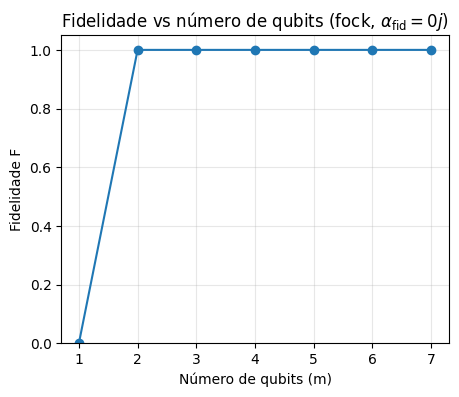

In [8]:
# Cria o estado inicial
def build_state_field(dim_f, state_kind, N, alpha0, phi):
    if state_kind == "fock":
        state_i_field = qt.fock(dim_f, N)
    elif state_kind == "coherent":
        state_i_field = qt.coherent(dim_f, alpha0)
    elif state_kind == "cat":
        ket_p = qt.coherent(dim_f, alpha0)
        ket_m = qt.coherent(dim_f, -alpha0)
        norm = 1.0 / np.sqrt(2.0 + 2.0 * np.cos(phi) * np.exp(-2.0 * (abs(alpha0)**2)))
        state_i_field = (norm * (ket_p + np.exp(1j*phi)*ket_m)).unit()
    else:
        raise ValueError("state_kind inválido. Use 'fock', 'coherent' ou 'cat'.")
    return state_i_field

# Calcula a fidelidade considerando um alpha de deslocamento fixo para um dado número de qubits
def fidelidade_para_num_qubits(num_qubits_local,
                               state_kind, N, alpha0, phi,
                               kappa=1.0,
                               alpha_fid=0.0+0.0j):
    dim_q = 2
    N_max_local = 2 ** num_qubits_local

    # dimensão do campo: pelo menos N_max+1 e também maior que N, etc.
    dim_f_local = max(N_max_local + 1, N + 10)

    # Estado do campo (antes do deslocamento)
    state_i_field_local = build_state_field(dim_f_local, state_kind, N, alpha0, phi)

    # Estado inicial dos qubits |+>^{⊗m}
    state_i_qubits_local = [(qt.basis(2, 0) + qt.basis(2, 1)).unit()
                            for _ in range(num_qubits_local)]

    # Operadores e QFT
    sigma_m_local, a_local, qft_total_local = construir_operadores(num_qubits_local, dim_q, dim_f_local)
    n_op_local = a_local.dag() * a_local

    # Colapsos: para fidelidade, faz sentido tirar decoerência (QPE "ideal")
    c_ops_local = [np.sqrt(kappa) * a_local] 

    # Tempo de interação
    t_f_int_local = 1.0e-3 * (1.0 / kappa)
    t_list_round_local = np.array([0.0, t_f_int_local])

    # Calibração: g_k * t_f = 2π * 2^k / N_max
    g_list_local = [ (2*np.pi * (2**g) / N_max_local) / t_f_int_local
                     for g in range(num_qubits_local) ]
    g_list_local = g_list_local[::-1]

    # Hamiltoniano efetivo
    H_eff_local = 0
    for q in range(num_qubits_local):
        H_eff_local += g_list_local[q] * (a_local.dag() * a_local) * (sigma_m_local[q].dag() * sigma_m_local[q])

    H_td_local = [[H_eff_local, c_eff]]

    # Projetores para P(n) (pós-QFT)
    basis_states_local = construir_base_qubits(num_qubits_local)
    proj_list_local = [qt.tensor(s * s.dag(), qt.qeye(dim_f_local)) for s in basis_states_local]
    proj_list_qft_local = [qft_total_local * P * qft_total_local.dag() for P in proj_list_local]

    # Options para mcsolve (aqui vai rodar como SE, pois c_ops_local = [])
    opts_local = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                         store_states=False, store_final_state=True)

    seed_t_local = np.random.randint(1e9)

    # Ponto de teste no espaço de fase (α_fid); pela convenção W(-α)=..., usamos -α na hora do deslocamento
    alpha_eff = -alpha_fid
    state_displaced_local = apply_displacement(state_i_field_local, alpha_eff, dim_f_local)

    # Distribuição P_QPE(n; α_fid) via QPE
    Pn_displaced = Pn_via_QPE(state_i_qubits_local, state_displaced_local,
                              H_td_local, t_f_int_local, t_list_round_local,
                              c_ops_local, opts_local, seed_t_local, proj_list_qft_local)

    # Distribuição exata P_ex(n; α_fid) a partir do state_displaced_local
    max_n_sum_local = min(dim_f_local, 2 ** num_qubits_local)
    P_exact = np.zeros(max_n_sum_local)
    for n in range(max_n_sum_local):
        amp = (qt.basis(dim_f_local, n).dag() * state_displaced_local).full().item()
        P_exact[n] = np.abs(amp) ** 2

    if P_exact.sum() > 0:
        P_exact /= P_exact.sum()

    P_qpe = Pn_displaced[:max_n_sum_local]
    if P_qpe.sum() > 0:
        P_qpe /= P_qpe.sum()

    # Fidelidade clássica (equivalente à fidelidade quântica para estados diagonais)
    overlap = np.sum(np.sqrt(P_exact * P_qpe))
    F = overlap ** 2

    return F

def fidelidade_haroche_para_num_qubits(num_qubits_local,
                                       state_kind, N, alpha0, phi,
                                       kappa=1.0,
                                       alpha_fid=0.0+0.0j):
    dim_q = 2
    N_max_local = 2 ** num_qubits_local

    # dimensão do campo
    dim_f_local = max(N_max_local + 1, N + 10)

    # Estado do campo (inicial, antes de deslocar)
    state_i_field_local = build_state_field(dim_f_local, state_kind, N, alpha0, phi)

    # Qubits |+>^{⊗m}
    state_i_qubits_local = [(qt.basis(2, 0) + qt.basis(2, 1)).unit()
                            for _ in range(num_qubits_local)]

    # Operadores e QFT
    sigma_m_local, a_local, qft_total_local = construir_operadores(num_qubits_local, dim_q, dim_f_local)

    # Colapsos (mantendo decoerência)
    c_ops_local = [np.sqrt(kappa) * a_local]

    # Tempo de interação
    t_f_int_local = 1.0e-3 * (1.0 / kappa)
    t_list_round_local = np.array([0.0, t_f_int_local])

    # Calibração g_k t_f = 2π 2^k / N_max
    g_list_local = [ (2*np.pi * (2**g) / N_max_local) / t_f_int_local
                     for g in range(num_qubits_local) ]
    g_list_local = g_list_local[::-1]

    # Hamiltoniano efetivo
    H_eff_local = 0
    for q in range(num_qubits_local):
        H_eff_local += g_list_local[q] * (a_local.dag() * a_local) * (sigma_m_local[q].dag() * sigma_m_local[q])

    H_td_local = [[H_eff_local, c_eff]]

    # Projetores (IQFT + base computacional)
    basis_states_local = construir_base_qubits(num_qubits_local)
    proj_list_local = [qt.tensor(s * s.dag(), qt.qeye(dim_f_local)) for s in basis_states_local]
    proj_list_qft_local = [qft_total_local * P * qft_total_local.dag() for P in proj_list_local]

    # Options
    opts_local = Options(method='bdf', atol=1e-9, rtol=1e-7, nsteps=50000,
                         store_states=False, store_final_state=True)

    seed_t_local = np.random.randint(1e9)

    # Estado deslocado no ponto alpha_fid (mesma convenção W(-α))
    alpha_eff = -alpha_fid
    state_displaced_local = apply_displacement(state_i_field_local, alpha_eff, dim_f_local)

    # Distribuição P_QPE(n; alpha_fid) via QPE
    Pn_displaced = Pn_via_QPE(state_i_qubits_local, state_displaced_local,
                              H_td_local, t_f_int_local, t_list_round_local,
                              c_ops_local, opts_local, seed_t_local, proj_list_qft_local)

    # Normaliza e corta no máximo resolvido pela QPE
    max_n_sum_local = min(dim_f_local, 2 ** num_qubits_local)
    P_qpe = Pn_displaced[:max_n_sum_local]
    if P_qpe.sum() > 0:
        P_qpe /= P_qpe.sum()

    # Constrói rho_rec diagonal em Fock: rho_rec = sum_n P_qpe(n) |n><n|
    rho_data = np.zeros((dim_f_local, dim_f_local), dtype=complex)
    rho_data[np.arange(max_n_sum_local), np.arange(max_n_sum_local)] = P_qpe
    rho_rec = qt.Qobj(rho_data, dims=[[dim_f_local], [dim_f_local]])

    # Estado ideal (puro) no mesmo ponto alpha_fid
    psi_ideal = build_state_field(dim_f_local, state_kind, N, alpha0, phi)
    psi_ideal_disp = apply_displacement(psi_ideal, alpha_eff, dim_f_local)

    # Fidelidade à la Haroche: <psi_ideal| rho_rec |psi_ideal>
    F_H = (psi_ideal_disp.dag() * rho_rec * psi_ideal_disp).full().real.item()

    return F_H


#####
# Pedindo para plotar a fidelidade pelo número de qubits
#####

max_qubits = 7

# defina aqui o tipo de estado que quer testar
state_kind = "fock"       # "fock", "coherent" ou "cat"
N = 3                     # se fock; se for coerente/gato, N ainda é usado em build_state_field, mas não como número médio
alpha0 = np.sqrt(3.0)#1.5 + 0.0j       # para coherent/cat
phi = 0.0                 # fase do gato (0 par, np.pi ímpar)
kappa = 1.0               # o mesmo que você já usa

alpha_fid = 0.0 + 0.0j    # ponto no espaço de fase usado para a fidelidade

# Fidelidade clássica
fidelidades = np.zeros(max_qubits)
qubits_list = np.arange(1, max_qubits+1)

for m in qubits_list:
    Fm = fidelidade_para_num_qubits(m, state_kind, N, alpha0, phi,
                                    kappa=kappa, alpha_fid=alpha_fid)
    fidelidades[m-1] = Fm
    print(f"m = {m}, fidelidade = {Fm:.6f}")

# Fidelidade quântica
fidelidades_H = np.zeros(max_qubits)
qubits_list = np.arange(1, max_qubits+1)

for m in qubits_list:
    Fm = fidelidade_haroche_para_num_qubits(m, state_kind, N, alpha0, phi,
                                            kappa=kappa, alpha_fid=alpha_fid)
    fidelidades_H[m-1] = Fm
    print(f"m = {m}, F_H (Haroche) = {Fm:.6f}")

# Plot da fidelidade vs número de qubits
plt.figure(figsize=(5,4))
plt.plot(qubits_list, fidelidades_H, 'o-', linewidth=1.5)
plt.xlabel("Número de qubits (m)")
plt.ylabel("Fidelidade F")
plt.ylim(0.0, 1.05)
plt.grid(True, alpha=0.3)
plt.title(rf"Fidelidade vs número de qubits ({state_kind}, $\alpha_\mathrm{{fid}}={alpha_fid}$)")
plt.show()

# Fidelidade quântica

definição do qutip no chat gpt

Fidelidade tipo Haroche (via Wigner) F_H = 0.9999669267701234
Correlação de forma entre W_QPE e W_ideal = 0.9999669267701237


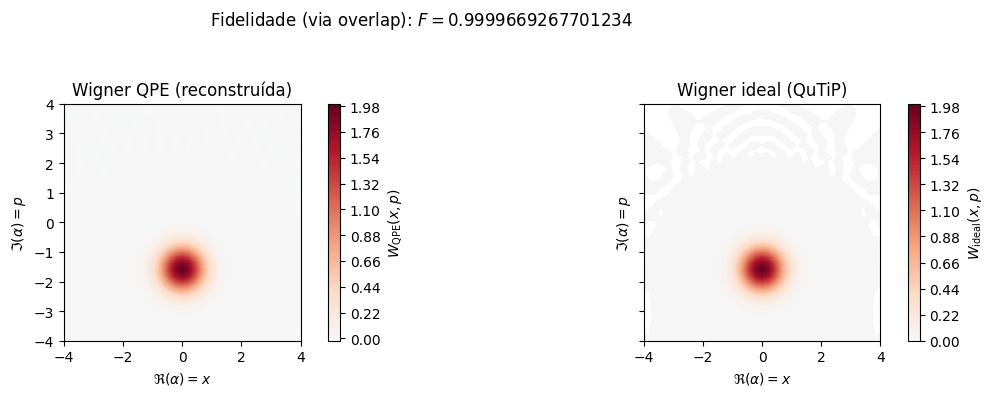

In [61]:
# ==========================
# 1) Função para o estado ideal
# ==========================
def build_state_field(dim_f, state_kind, N, alpha0, phi):
    """
    Constrói o estado ideal do campo em dim_f dimensões de Fock.
    state_kind: "fock", "coherent" ou "cat".
    """
    if state_kind == "fock":
        state_i_field = qt.fock(dim_f, int(N))
    elif state_kind == "coherent":
        state_i_field = qt.coherent(dim_f, alpha0)
    elif state_kind == "cat":
        ket_p = qt.coherent(dim_f, alpha0)
        ket_m = qt.coherent(dim_f, -alpha0)
        norm = 1.0 / np.sqrt(2.0 + 2.0 * np.cos(phi) * np.exp(-2.0 * (abs(alpha0)**2)))
        state_i_field = (norm * (ket_p + np.exp(1j*phi)*ket_m)).unit()
    else:
        raise ValueError("state_kind inválido. Use 'fock', 'coherent' ou 'cat'.")
    return state_i_field

# ==========================
# 2) Ler CSV e reconstruir grid da QPE
# ==========================
nome_arquivo_csv = "/media/solakerino/HD_Work7/DD/Quantum_Phase_Estimation_N_photons/data/wigner/coherent/wigner_coherent_0.0_m7_dimf128.csv"

df = pd.read_csv(nome_arquivo_csv)

# pivot: linhas = p, colunas = x
df_pivot = df.pivot(index="p", columns="x", values="W")
df_pivot = df_pivot.sort_index(axis=0).sort_index(axis=1)

pvec = df_pivot.index.values        # eixo p (imag α)
xvec = df_pivot.columns.values      # eixo x (real α)
wigner_qpe = df_pivot.values        # matriz W_QPE(p,x), shape (Np,Nx)

X_w, P_w = np.meshgrid(xvec, pvec)

# ==========================
# 3) Construir Wigner ideal no MESMO grid e MESMA norma
# ==========================

# --- parâmetros do estado ideal (ajuste aqui) ---
state_kind = "coherent"          # "fock", "coherent" ou "cat"
N = 3                       # se fock; para cat/coherent não entra como n_bar
alpha0 = -np.sqrt(2.5)       # mesmo α0 da simulação QPE
phi = np.pi                 # fase do gato (0 par, π ímpar)
dim_f = 2**6                  # mesma dimensão de Fock usada na QPE

# estado ideal e densidade
state_ideal = build_state_field(dim_f, state_kind, N, alpha0, phi)
rho_ideal = state_ideal * state_ideal.dag()

# grid de QUADRATURAS para o QuTiP (X,P) relacionado ao grid de deslocamentos α=x+ip
# a = (X + iP)/sqrt(2)  ⇒  X = sqrt(2)*Re(α)=sqrt(2)*x,  P = sqrt(2)*Im(α)=sqrt(2)*p
x_qt = np.sqrt(2.0) * xvec
p_qt = np.sqrt(2.0) * pvec

# QuTiP retorna W(x_qt,p_qt) em convenção padrão; PRL: W_PRL = π * W_qutip
W_qt = qt.wigner(rho_ideal, x_qt, p_qt)     # shape (Nx_qt, Np_qt)
W_ideal = (2*np.pi * W_qt).T                  # shape (Np,Nx), compatível com wigner_qpe

# ==========================
# 4) Calcular overlap F_W e correlação de forma
# ==========================
dx = xvec[1] - xvec[0]
dp = pvec[1] - pvec[0]
area = dx * dp

# auto-overlaps
I_idid   = np.sum(W_ideal    * W_ideal)    * area   # ideal
I_qpeqpe = np.sum(wigner_qpe * wigner_qpe) * area   # QPE bruta

# 4a) Renormalizar W_QPE para ter mesma "pureza" (mesma norma L2) que a ideal
if I_qpeqpe == 0:
    wigner_qpe_scaled = np.zeros_like(wigner_qpe)
else:
    s = np.sqrt(I_idid / I_qpeqpe)
    wigner_qpe_scaled = s * wigner_qpe

# overlap entre QPE (renormalizada) e ideal
num_scaled = np.sum(wigner_qpe_scaled * W_ideal) * area

# Fidelidade tipo Haroche (garantidamente |F_H| ≤ 1)
if I_idid == 0:
    F_H = 0.0
else:
    F_H = np.real(num_scaled / I_idid)

# 4b) Correlação de forma (independente de escala global, também ∈[-1,1])
norm_qpe = np.sqrt(I_qpeqpe)
norm_id  = np.sqrt(I_idid)
if norm_qpe == 0 or norm_id == 0:
    F_corr = 0.0
else:
    num_raw = np.sum(wigner_qpe * W_ideal) * area
    F_corr = np.real(num_raw / (norm_qpe * norm_id))

print(f"Fidelidade tipo Haroche (via Wigner) F_H = {F_H}")
print(f"Correlação de forma entre W_QPE e W_ideal = {F_corr}")

# ==========================
# 5) Plotar as duas Wigners lado a lado
# ==========================
# faixa de cores simétrica em torno de zero
vmax_plot = max(np.max(np.abs(wigner_qpe)), np.max(np.abs(W_ideal)))
vmax_plot = min(vmax_plot * 1.05, 2.0)   # opcional: limitar a ~2 como PRL
vmin_plot = -vmax_plot

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle(rf"Fidelidade (via overlap): $F={F_H}$",
    fontsize=12
)

# QPE
ax1 = axes[0]
c1 = ax1.contourf(X_w, P_w, wigner_qpe, 100, cmap='RdBu_r',
                  vmin=vmin_plot, vmax=vmax_plot)
ax1.set_title("Wigner QPE (reconstruída)")
ax1.set_xlabel(r"$\Re(\alpha)=x$")
ax1.set_ylabel(r"$\Im(\alpha)=p$")
ax1.set_aspect('equal')
plt.colorbar(c1, ax=ax1, label=r"$W_{\mathrm{QPE}}(x,p)$")

# Ideal
ax2 = axes[1]
c2 = ax2.contourf(X_w, P_w, W_ideal, 100, cmap='RdBu_r',
                  vmin=vmin_plot, vmax=vmax_plot)
ax2.set_title("Wigner ideal (QuTiP)")
ax2.set_xlabel(r"$\Re(\alpha)=x$")
ax2.set_ylabel(r"$\Im(\alpha)=p$")
ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2, label=r"$W_{\mathrm{ideal}}(x,p)$")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()